In [1]:
import torch, gc, os
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.plot import plot_loss, plot_train_val_evaluators, plot_evaluator
from utils.save import get_train_data

from models.load import ModelSetup, create_model_from_setup
from utils.save import check_best, end_train, TrainingInfo
from utils.data import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.coco_eval import get_ar_ap


## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device.upper()}]")

if use_gpu:
    torch.cuda.empty_cache()

This notebook will running on device: [CUDA]


In [3]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"

## train for 20 epoch first.
all_model_setups = [
    # ModelSetup(
    #     name="original",
    #     use_clinical=False,
    #     use_custom_model=False,
    #     use_early_stop_model=True,
    # ),

    # this setup works perfectly, so we try this setup in our newer code, does it work there? A: 

    ## small model with this one works.
    ModelSetup(
        name="small_custom_without_clinical",
        use_clinical=True,
        use_custom_model=True,
        use_early_stop_model=False,
        backbone='resnet50',
        optimiser='sgd',
        lr=0.0005,
        pretrained=True,
        dataset_model=  "unified",
        weight_decay=0.00005,
    ),

    
    # ModelSetup(
    #     name="custom_with_clinical",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     backbone='resnet50',
    #     pretrained=False,
    #     record_training_performance = False,
    # ),

    # ModelSetup(
    #     name="custom_with_clinical",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=False,
    #     backbone='resnet50',
    #     lr=0.0005,
    #     optimiser='sgd',
    #     pretrained=True,
    #     record_training_performance = False,
    # ),

    # ModelSetup(
    #     name="custom_with_clinical",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=False,
    #     backbone='resnet50',
    #     lr=0.0005,
    #     optimiser='sgd',
    #     pretrained=True,
    #     record_training_performance = False,
    # ),
]

In [4]:
labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

iou_thrs = np.array(
        [
            0.00,
            0.05,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95,
            1.0,
        ]
    )

In [5]:
num_epochs = 30
train_infos = []

In [11]:
model_setup

ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=False, name='custom_without_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=0.05, pretrained=True, record_training_performance=False)

In [9]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 5e-05
)

In [12]:
print(f"Model size: {sum([param.nelement()  for param in model.parameters()]):,}")


Model size: 43,943,923


In [28]:
torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)(torch.randn(1, 3, 48, 48)).shape

torch.Size([1, 3, 24, 24])

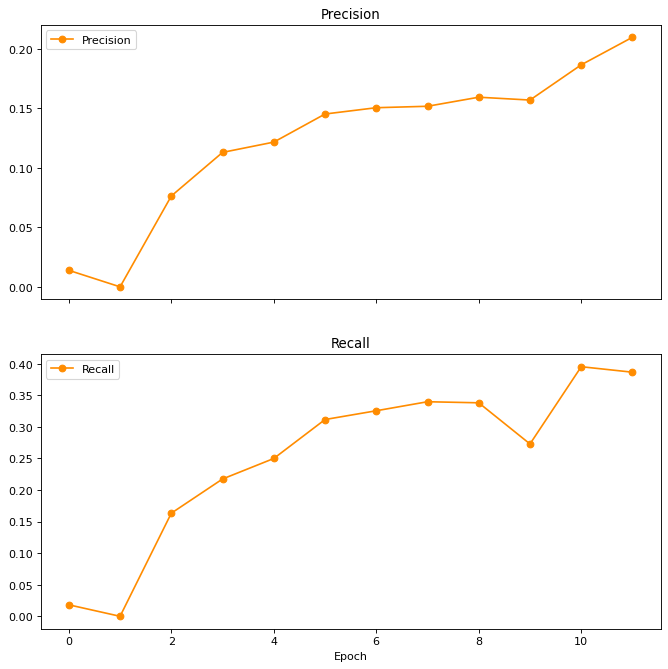

====================| Epoch [12] Done | It has took [26.13] min, Avg time: [130.66666666666666] sec/epoch | Estimate time for [100] epochs: [217.78] min |====================
====================Training model: [custom_without_clinical]====================
Epoch: [13]  [  0/104]  eta: 0:01:25  lr: 0.000500  loss: 0.1999 (0.1999)  loss_classifier: 0.0094 (0.0094)  loss_box_reg: 0.0003 (0.0003)  loss_mask: 0.1846 (0.1846)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 0.8241  data: 0.5482  max mem: 3985
Epoch: [13]  [ 10/104]  eta: 0:01:19  lr: 0.000500  loss: 0.4236 (0.3703)  loss_classifier: 0.0451 (0.0469)  loss_box_reg: 0.0204 (0.0224)  loss_mask: 0.2355 (0.2770)  loss_objectness: 0.0145 (0.0170)  loss_rpn_box_reg: 0.0034 (0.0070)  time: 0.8448  data: 0.5639  max mem: 3985


KeyboardInterrupt: 

In [8]:
from  datetime import datetime

for model_setup in all_model_setups:
    
    train_info = TrainingInfo(model_setup)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": "unified",
        "bbox_to_mask": True,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=4
    )

    model = create_model_from_setup(
        labels_cols,
        model_setup,
        image_size=512,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
        clinical_input_channels=32,
        clinical_num_len=9,
        clinical_conv_channels=64,
        fuse_conv_channels=64,
    )
    
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    print(f"Model size: {sum([param.nelement()  for param in model.parameters()]):,}")

    optimizer = torch.optim.SGD(
        params,
        lr=0.0005,
        momentum=0.9,
        weight_decay=0.00005, # decrase the weight decay a little bit, and see how it affect the result.
    )

    # optimizer = torch.optim.AdamW(
    #     params, lr=0.0001, betas=(0.9, 0.999), weight_decay=0.05,
    # )

    lr_scheduler = None

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    ## Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{model_setup.name}]")

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()

        train_loger = xami_train_one_epoch(
            model, optimizer, train_dataloader, device, train_info.epoch, print_freq=10,
        )

        train_info.train_data.append(get_train_data(train_loger))

        plot_loss(train_info.train_data)
        ################################################################

        ### update the learning rate
        if not lr_scheduler is None:
            lr_scheduler.step()

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        ### evaluate on the validation dataset
        # train_evaluator = xami_evaluate(
        #     model, train_dataloader, device=device, params_dict=eval_params_dict
        # )

        # train_info.train_evaluators.append(train_evaluator)

        val_evaluator = xami_evaluate(
            model, val_dataloader, device=device, params_dict=eval_params_dict
        )

        train_info.val_evaluators.append(val_evaluator)

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()
        
        # plot_evaluator(
        #     train_info.val_evaluators, iouThr=0.5, areaRng="all", maxDets=10,
        # )

        plot_evaluator(
            # train_info.train_evaluators,
            train_info.val_evaluators,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        current_time = datetime.now()
        sec_took = (current_time - train_info.start_t).seconds
        speed =  sec_took/train_info.epoch
        
        print_f.print_title(
            f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min |"
        )

        #######################################################################################

        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                train_info, eval_params_dict, model, test_dataloader, device
            )

    val_ar, val_ap = get_ar_ap(train_info.val_evaluators[-1])

    train_info = end_train(
        train_info, model, eval_params_dict, val_ar, val_ap, test_dataloader, device
    )

    train_infos.append(train_info)


    ## what's the best epoch to check if the model is trainable. # 30? #50? #let's train multiple model see when it converge usually.



In [ ]:
for idx, train_info in enumerate(train_infos):
    print("="*40 + f"For Training [{train_info.model_setup.name}]" + "="*40)
    print(train_info.model_setup)
    print("="*40)  
    print(f"Best AR validation model has been saved to: [{train_info.best_ar_val_model_path}]")
    print(f"Best AP validation model has been saved to: [{train_info.best_ap_val_model_path}]")
    print(f"The final model has been saved to: [{train_info.final_model_path}]")